<a href="https://colab.research.google.com/github/thinhhoUB/Sentiment-Analysis/blob/main/Sentiment-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 7: Text Classification with Naive Bayes

## Introduction:

In this project, we will implement **Naive Bayes classification** algorithm and explore its **application** in real world problems. FIrst, we will have a **binary** classification of predicting a movie review is either **positive** or **negative**. Then, we will extend it with **multiclass** classification when predicting which **newsgroups** a post belongs to based on the text of the post.

## Binary Classification: Movie reviews

In [ ]:
import pandas as pd                                            #library for working with dataframe
import numpy as np                                             #library for working with array
import re                                                      #library for working with text
from sklearn.model_selection import train_test_split           #library to split testing and training dataset
from collections import Counter                                #library to count numbers of word in string

In [ ]:
#loading movies dataset
movies = pd.read_csv("movie_reviews.zip")
movies.head()

,review,sentiment
0,"This film is absolutely awful, but nevertheles...",negative
1,Well since seeing part's 1 through 3 I can hon...,negative
2,I got to see this film at a preview and was da...,positive
3,This adaptation positively butchers a classic ...,negative
4,Råzone is an awful movie! It is so simple. It ...,negative


Main idea about **Naive Bayes algorithm**:

$$p(negative/text) = p(text/negative)p(negative)$$
$$p(positive/text) = p(text/positive)p(positive)$$

where $p(text/negative)$ will be **likelihood function** and $p(negative)$ is **probability of being negative**. Same for **positive** case.

#### Likelihood function and probability of positive/negative

In order to obtain likelihood function, we pretend **each word** in text is **independent** event. Therefore, the **likelihood function** can be written as following:

$$p(text/negative)=p(word_1/negative)*p(word_2/negative)*....*p(word_n.negative)$$

In order to have those probabilities, first, we have to build a **word count** dataframe where we count the **appearance** of each single word in either **positive** or **negative** class. To avoiding feeding information and reduce the correctness of model, we will **split** into training set and testing set which we get a **word count** dataframe from **train set** then use it to predict **test set**:

In [ ]:
train_movies,test_movies=train_test_split(movies,test_size=0.5,random_state=1)

Extracting out **postive** and **negative** reviews separately:

In [ ]:
positive= train_movies[train_movies['sentiment']=='positive'].reset_index(drop=True)
negative= train_movies[train_movies['sentiment']=='negative'].reset_index(drop=True)

For every **positive** reviews, we will count **how many times each word appears** ?

In [ ]:
counter_lst=[]
for i in range(positive.shape[0]):
    #iterate every row
    review=positive.loc[i,'review']
    #get the review detail
    review=review.lower()
    review=re.findall(r"[a-z']+",review)
    if 'br' in review: review.remove('br')
    #process to delete unmeaningful character such as new line
    counter=Counter(review)
    #obtain count of 1 review
    counter_lst.append(counter)
    #add to list of count

Next step will be total appearance of each word in all **positive** reviews:

`total_count` function will assist us with the task:

In [ ]:
def total_count(all_counters):
    total_count= all_counters[0]
    for i in range(1,len(all_counters)):
        total_count+=all_counters[i]
    return total_count

In [ ]:
words_count_positive=total_count(counter_lst)

Following same steps for **negative** reviews:

In [ ]:
#list of word count for every reviews
counter_lst_1=[]
for i in range(negative.shape[0]):
    review=negative.loc[i,'review']
    review=review.lower()
    review=re.findall(r"[a-z']+",review)
    if 'br' in review: review.remove('br')
    counter=Counter(review)
    counter_lst_1.append(counter)
#word count total for all negative reviews
words_count_negative= total_count(counter_lst_1)

In order to be more convenient in access and manipulate, we transform into **word count dataframe**:

In [ ]:
words_count_positive=pd.DataFrame([dict(words_count_positive)]).T
words_count_negative=pd.DataFrame([dict(words_count_negative)]).T
wc=words_count_negative.merge(words_count_positive,how='outer',left_index=True,right_index=True)
wc = wc.rename({'0_x': 'negative', '0_y': 'positive'}, axis=1)  #change the columns'names

In [ ]:
#quick look at our output
wc.head()

,negative,positive
',371.0,378.0
'',2.0,2.0
''after,NaN,1.0
''bad,NaN,1.0
''cannibal,1.0,NaN


In [ ]:
#checking null value because there is probably some words appear in positive but not negative and vice vers
wc.isna().sum()

negative    18960
positive    16724
dtype: int64

In [ ]:
#instead of NA, we fill them with number 0
wc=wc.fillna(0)

Here, we encouter problem of **0 probability** just because only **one word** has word count of 0. Hence, we will apply **Laplace smoothing** by adding 1 to every word count:

In [ ]:
wc=wc+1

How about some **distraction word** such as: the, a, as, etc. They are **unecessary** that we can eliminate them from our word count database:

In [ ]:
with open('stopwords.txt') as f:
    stops = f.read()
stops = stops.split(',')
wc = wc.drop(stops, errors='ignore')
wc=wc.drop('br')

Instead of likelihood function which is calculated by **multiplying**, we will use **log likelihood** which is **adding**. From that, we can avoid the problem of multiplying **two extreme small** numbers which lead to 0:

Adding two new columns: log likelihood of positive and log likelihood of negative for every word

In [ ]:
wc['log_like_pos']=np.log10(wc['positive']/(wc.sum()['positive']))
wc['log_like_neg']=np.log10(wc['negative']/(wc.sum()['negative']))

Finishing with **likelihood function**, we calculate **probability of positive and negative**:

In [ ]:
#total sum of word count for postive/negative
tot=wc.sum()
tot

negative        817421.000000
positive        860919.000000
log_like_pos   -341043.185919
log_like_neg   -341630.655666
dtype: float64

In [ ]:
#prob of positive
pos_prob=tot['positive']/(tot['positive']+tot['negative'])
#prob of negative
neg_prob=tot['negative']/(tot['positive']+tot['negative'])

In [ ]:
#list of all available words to calculate the log likelihood
available_words=list(wc.index)

Now, we are ready for predicting. However, can we predict **positive/negative** just based on words in text body? Let's look at the WordCloud where the frequency of word can be demonstrated by the size:

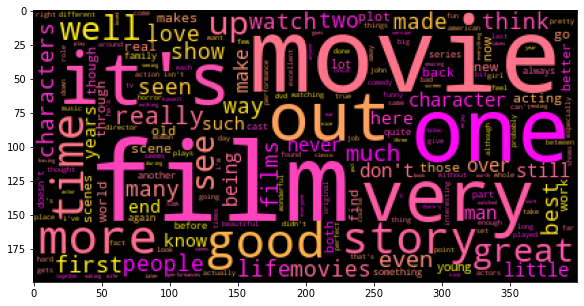

In [ ]:
from wordcloud import WordCloud

cloud = WordCloud(max_words=200, background_color='black', colormap='spring')
cloud.generate_from_frequencies(wc['positive'])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(cloud);

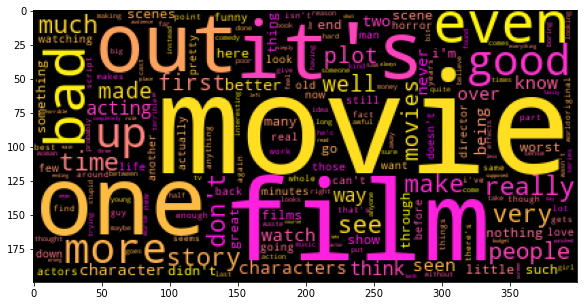

In [ ]:
cloud = WordCloud(max_words=200, background_color='black', colormap='spring')
cloud.generate_from_frequencies(wc['negative'])
plt.figure(figsize=(10, 5))
plt.imshow(cloud);

It is quite interesting that, for either **positive** or **negative** reviews, the top most frequency word is really similar to each other. When the word gets smaller, they tends to be different. Hence, we can expect our model's prediction is **correct but not with high accuracy**.

#### Predicting:

First of all, before using **Naive Bayes**, we also have to process the text as same as we did for training set with `preprocessing` function

In [ ]:
def preprocessing(reviews):
    reviews=reviews.lower()
    reviews=re.findall(r"[a-z']+",reviews)
    if 'br' in reviews: 
        reviews.remove('br')
    return reviews

Calculating **log likelihood** of all words in text body of review with `calculate_log_like` function:

In [ ]:
def calculate_log_like(review):
    #take a review as input
    processed_reviews= preprocessing(review)
    #preprocess it
    log_like_pos=0
    log_like_neg=0
    for w in processed_reviews:
        #iterate through every word
        if w not in available_words:
        #if it is not in word count database continue to the next
            continue
        else:
        #if it is, keep adding to both the positive log likelihood and negative log likelihood
            log_like_pos+= wc.loc[w,'log_like_pos']
            log_like_neg+= wc.loc[w,'log_like_neg']
    return (log_like_pos,log_like_neg) 

`rev_probs` function will return probability of being positve and negative

In [ ]:
def rev_probs(review):
    log_like_pos,log_like_neg= calculate_log_like(review)
    pos= log_like_pos+np.log10(pos_prob)
    neg= log_like_neg+np.log10(neg_prob)
    return (pos,neg)

We apply function `classify` to every reviews in testing set to have the **final prediction** :

In [ ]:
def classify(row):
    pos,neg=rev_probs(row['review'])
    #calculate probability of being positve and negative
    if pos>neg:
    #if positive prob is greater, return 'positive', or 'negative' otherwise
        return "positive"
    else:
        return "negative"

In [ ]:
#quick look at testing set
test_movies=test_movies.reset_index(drop=True)
test_movies.head()

,review,sentiment
0,I saw this recent Woody Allen film because I'm...,negative
1,I thought this film was just about perfect. Th...,positive
2,"I really wanted to like this movie, but it nev...",negative
3,You know? Our spirit is based on that revoluti...,positive
4,"Today actresses happily gain weight, dye their...",positive


Specifically for this, in order to **time saving**, we will predict **only first 1000 reviews**:

In [ ]:
subset= test_movies.head(1000)

Predicting and add a new column `prediction`:

In [ ]:
subset['prediction']=subset.apply(classify,axis=1)

/var/folders/mt/pl4zs_qn1px061cxgp0z1h9r0000gn/T/ipykernel_8016/3152107045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['prediction']=subset.apply(classify,axis=1)


In [ ]:
confusion_matrix = pd.crosstab(subset['prediction'],subset['sentiment'])
confusion_matrix

sentiment,negative,positive
prediction,,
negative,445,85
positive,62,408


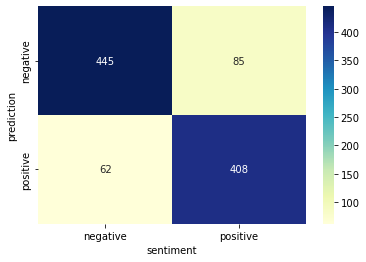

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix,annot=True, fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
subset['correctness']=subset['sentiment'] == subset['prediction']

/var/folders/mt/pl4zs_qn1px061cxgp0z1h9r0000gn/T/ipykernel_8016/1030059096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['correctness']=subset['sentiment'] == subset['prediction']


In [ ]:
accuracy= len(subset[subset['correctness']==True])/1000

In [ ]:
accuracy

0.853

In [ ]:
print(f'The accuracy of our Naive Bayes model is {accuracy*100}%')

The accuracy of our Naive Bayes model is 85.3%


**Recall** is how good the model predicted **positive** and **negative** case:

In [ ]:
positive_recall=445/(445+62)*100
positive_recall="{:.2f}".format(positive_recall)
print(f'The recall of postive of our model is {positive_recall}%')

The recall of postive of our model is 87.77%


In [ ]:
negative_recall=408/(408+85)*100
negative_recall="{:.2f}".format(negative_recall)
print(f'The recall of postive of our model is {positive_recall}%')

The recall of postive of our model is 87.77%


Our model perform pretty good on both **positive and negative** case when the **recall** are equal to each other.

Let's further explore the result by calculate the **difference in probability** between classes:

In [ ]:
def difference(row):
    pos,neg=rev_probs(row['review'])
    return np.abs(pos-neg)

In [ ]:
subset['prob_diff']=subset.apply(difference,axis=1)
subset.head()

/var/folders/mt/pl4zs_qn1px061cxgp0z1h9r0000gn/T/ipykernel_8016/2900232543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['prob_diff']=subset.apply(difference,axis=1)


,review,sentiment,prediction,correctness,prob_diff
0,I saw this recent Woody Allen film because I'm...,negative,negative,True,1.797114
1,I thought this film was just about perfect. Th...,positive,negative,False,0.578816
2,"I really wanted to like this movie, but it nev...",negative,negative,True,6.284719
3,You know? Our spirit is based on that revoluti...,positive,positive,True,1.941291
4,"Today actresses happily gain weight, dye their...",positive,positive,True,20.755634


Using **box plot** to visualize the **difference in probability** between correctly and incorrectly classified:

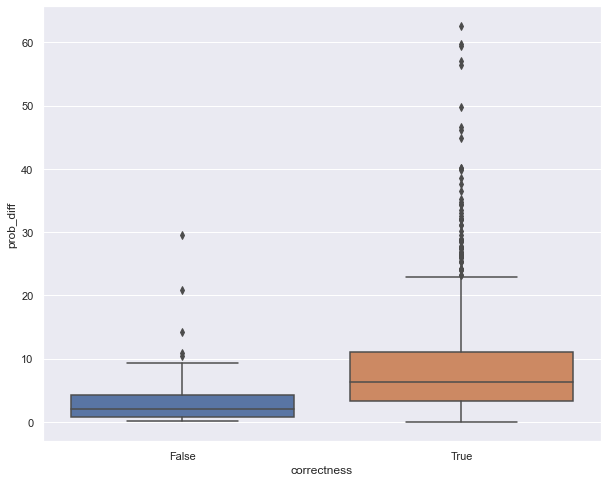

In [ ]:
plt.figure(figsize=(10,8))
sns.set_theme()
sns.boxplot(data=subset,y='prob_diff',x='correctness')
plt.show()

As we can see, when a review is **correctly classified**, the difference between probability is **much bigger** than when a review is **misclassified**.

## Multi class classification: Newsgroup

Following exactly the same pipelines of **binary classification**, we apply to classify which news groups the text body will belong to?

In [ ]:
from zipfile import ZipFile
with ZipFile("newsgroups.zip",'r') as zipped:
    txt=zipped.read('newsgroups.txt').decode(encoding='utf8',errors='ignore')

As the file comes under the **text file**, we have to process and convert it into the dataframe:

In [ ]:
#quick glance at the format of text file
print(txt[:1200])

Newsgroup: rec.autos
From: gwm@spl1.spl.loral.com (Gary W. Mahan)
Subject: Re: Are BMW's worth the price?            


>sure sounds like they got a ringer.  the 325is i drove was definitely
>faster than that.  if you want to quote numbers, my AW AutoFile shows
>0-60 in 7.4, 1/4 mile in 15.9.  it quotes Car and Driver's figures
>of 6.9 and 15.3.  oh, BTW, these numbers are for the 325i.

Car and Driver rated the 325is (1988) at 7.2 0-60 , 1/4 at 15.2 (after 30k miles) last time I checked 8#}.

Automobile magazine rated new 325is 1/4 mile@16.2.

Gee , aint quotiin funner than the dickens!

Sounds like we need a race.  I'll let you have the newer version.  Can someone out there lend me a 1988 325is for a day 8-].  I wont hurt it, I promise.

>i don't know how the addition of variable valve timing for 1993 affects it.
>but don't take my word for it.  go drive it.

Actually I will take your word on it.  I refuse to test it (new 325is) because
I love BMW's and would probably want to buy it.

Here, we will form a dataset with **4** columns: **newsgroup,from,subject, and body**

To differentiate between each news, it will be separated by the keyword **Newsgroup**:

In [ ]:
all_news=txt.split('Newsgroup: ')

In [ ]:
df=[]
for n in range(1,len(all_news)):
    if "Subject" in all_news[n] and len(re.findall(r'From:.*\n\n\n',all_news[n],re.S)) != 0:
        dict={}
        dict['newsgroup']=re.findall(r'^(.*)\n',all_news[n])[0]
        dict['from']=re.findall(r"From:(.*)",all_news[n])[0]
        dict['subject']=re.findall(r"Subject:(.*)",all_news[n])[0]
        dict['body']=re.findall(r'\n\n\n.*',all_news[n],re.S)[0].replace('\n','')
        df.append(dict)
    else:
        continue

Our final product:

In [ ]:
news=pd.DataFrame(df)
news.head()

,newsgroup,from,subject,body
0,rec.autos,gwm@spl1.spl.loral.com (Gary W. Mahan),Re: Are BMW's worth the price?,>sure sounds like they got a ringer. the 325i...
1,sci.med,davec@ecst.csuchico.edu (Dave Childs),Dental Fillings question,I have been hearing bad thing about amalgam de...
2,alt.atheism,"""Robert Knowles"" <p00261@psilink.com>",Re: Islamic marriage?,">DATE: Tue, 6 Apr 1993 00:11:49 GMT>FROM: ..."
3,rec.sport.baseball,sepinwal@mail.sas.upenn.edu (Alan Sepinwall),Re: WFAN,In article <1993Apr16.174843.28111@cabell.vcu....
4,talk.religion.misc,rwd4f@poe.acc.Virginia.EDU (Rob Dobson),Re: A Message for you Mr. President: How do y...,In article <visser.735284180@convex.convex.com...


#### Likelihood function and probability of each newsgroup:

Once again, we start by implementing of **world count for every newsgroup**:

In [ ]:
train_news,test_news= train_test_split(news,test_size=0.5,random_state=28)

Separating out by **each newsgroup**:

In [ ]:
newsgroup_grouped_data=[]
for e in train_news['newsgroup'].unique():
    newsgroup= train_news[train_news['newsgroup']==e].reset_index(drop=True)
    newsgroup_grouped_data.append(newsgroup)

Counting word for each newsgroup **individually** with function `individual_word_count`:

> - The input: dataset of 1 newsgroup
> - The output: list counting of each word's appearance in each body in that newsgroup

In [ ]:
def individual_word_count(dataset):
    counter_lst=[]
    for i in range(dataset.shape[0]):
        body=dataset.loc[i,'body']
        body=body.lower()
        body=re.findall(r"[a-z']+",body)
        if 'br' in body: body.remove('br')
        counter=Counter(body)
        counter_lst.append(counter)
    return counter_lst

Applying the `total_count` function to have the counting of each word's appearance in a **specific** newsgroup:


In [ ]:
one_group_wc=total_count(individual_word_count(newsgroup_grouped_data[0]))
final_wc=pd.DataFrame.from_dict(one_group_wc, orient='index')

We repeat the process for **other remaining group** and **merge** it to have **a complete word count dataframe**:

In [ ]:
for i in range(1,len(newsgroup_grouped_data)):
#iterate over all the newsgroup
    one_group_wc=total_count(individual_word_count(newsgroup_grouped_data[i]))
    #apply the process of word count for 1 group
    final_wc=final_wc.merge(pd.DataFrame.from_dict(one_group_wc, orient='index'),
                            how='outer',left_index=True,right_index=True) 
    #merge the result to final dataframe
final_wc.columns = train_news['newsgroup'].unique()
#change names of columns 

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [ ]:
#quick glance at final output
final_wc.head()

,talk.religion.misc,rec.motorcycles,rec.sport.hockey,alt.atheism,rec.sport.baseball,rec.autos,sci.med,sci.electronics
',30.0,267.0,154.0,86.0,78.0,160.0,28.0,27.0
'',2.0,4.0,6.0,8.0,NaN,NaN,2.0,NaN
''',NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
''''',NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
''ahmadya,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, as we proceed, 

> - Replace Null Value
> - Laplace Transform to avoid **0 probability**
> - Eliminate **noise word**

In [ ]:
final_wc=final_wc.fillna(0)
final_wc+=1
final_wc = final_wc.drop(stops, errors='ignore')

Calculating and adding log likelihood function:

In [ ]:
tot=final_wc.sum()

In [ ]:
for a in train_news['newsgroup'].unique():
    final_wc['log_like_'+a]= np.log10(final_wc[a]/tot[a])
final_wc.head()

,talk.religion.misc,rec.motorcycles,rec.sport.hockey,alt.atheism,rec.sport.baseball,rec.autos,sci.med,sci.electronics,log_like_talk.religion.misc,log_like_rec.motorcycles,log_like_rec.sport.hockey,log_like_alt.atheism,log_like_rec.sport.baseball,log_like_rec.autos,log_like_sci.med,log_like_sci.electronics
',31.0,268.0,155.0,87.0,79.0,161.0,29.0,28.0,-3.548770,-2.599651,-2.925515,-3.134701,-3.150294,-2.827060,-3.649375,-3.589914
'',3.0,5.0,7.0,9.0,1.0,1.0,3.0,1.0,-4.563010,-4.328816,-4.270749,-4.119978,-5.047921,-5.033886,-4.634652,-5.037072
''',1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,-5.040131,-5.027786,-4.814817,-5.074220,-4.746891,-5.033886,-5.111773,-5.037072
''''',1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,-5.040131,-5.027786,-4.814817,-5.074220,-5.047921,-5.033886,-5.111773,-5.037072
''ahmadya,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-4.739101,-5.027786,-5.115847,-5.074220,-5.047921,-5.033886,-5.111773,-5.037072


Calculating **probability of each newsgroup**:

In [ ]:
autos_prob=tot['rec.autos']/(tot.sum())
med_prob=tot['sci.med']/(tot.sum())
atheism_prob=tot['alt.atheism']/(tot.sum())
baseball_prob=tot['rec.sport.baseball']/(tot.sum())
religion_prob=tot['talk.religion.misc']/(tot.sum())
hockey_prob=tot['rec.sport.hockey']/(tot.sum())
electronics_prob=tot['sci.electronics']/(tot.sum())
motorcycles_prob=tot['rec.motorcycles']/(tot.sum())

In [ ]:
available_words=list(final_wc.index)

#### Classifying:

Function `calculate_prob_each_newstype` will take a **body** as an input and return probability for each class:

In [ ]:
def calculate_prob_each_newstype(reviews):
    processed_reviews=preprocessing(reviews)
    log_like_talkreligionmisc=0
    log_like_recmotorcycles=0
    log_like_recsporthockey=0
    log_like_altatheism=0
    log_like_recsportbaseball=0
    log_like_recautos=0
    log_like_scimed=0
    log_like_scielectronics=0
    for w in processed_reviews:
        if w not in available_words:
            continue
        else:
            log_like_talkreligionmisc+=final_wc.loc[w,'log_like_talk.religion.misc']
            log_like_recmotorcycles+=final_wc.loc[w,'log_like_rec.motorcycles']
            log_like_recsporthockey+=final_wc.loc[w,'log_like_rec.sport.hockey']
            log_like_altatheism+=final_wc.loc[w,'log_like_alt.atheism']
            log_like_recsportbaseball+=final_wc.loc[w,'log_like_rec.sport.baseball']
            log_like_recautos+=final_wc.loc[w,'log_like_rec.autos']
            log_like_scimed+=final_wc.loc[w,'log_like_sci.med']
            log_like_scielectronics+=final_wc.loc[w,'log_like_sci.electronics']
    log_like_talkreligionmisc+=np.log10(religion_prob)
    log_like_recmotorcycles+=np.log10(motorcycles_prob)
    log_like_recsporthockey+=np.log10(hockey_prob)
    log_like_altatheism+=np.log10(atheism_prob)
    log_like_recsportbaseball+=np.log10(baseball_prob)
    log_like_recautos+=np.log10(autos_prob)
    log_like_scimed+=np.log10(med_prob)
    log_like_scielectronics+=np.log10(electronics_prob)
    return (log_like_talkreligionmisc, log_like_recmotorcycles,
    log_like_recsporthockey,log_like_altatheism,
    log_like_recsportbaseball,log_like_recautos,
    log_like_scimed,log_like_scielectronics)

In [ ]:
news_type=train_news['newsgroup'].unique()

Here, our `classify_alt` will follow this logic:

> - Taking the output of function `calculate_prob_each_newstype`, we obtains a set of **8** probability for each newsgroup

> - We find the **maximum** probability => the index(position) of that **maximum** probability

> - Return the **newsgroup** of that position

In [ ]:
def classify_alt(row):
    prob_each_newstype=calculate_prob_each_newstype(row['body'])
    max_prob= max(prob_each_newstype)
    index_of_type= prob_each_newstype.index(max_prob)
    return news_type[index_of_type]

In order to time saving, we will predict only first 1000 texts:

In [ ]:
test_news=test_news.reset_index(drop=True)
subset=test_news.tail(1000)

In [ ]:
subset['prediction']=subset.apply(classify_alt,axis=1)

/var/folders/mt/pl4zs_qn1px061cxgp0z1h9r0000gn/T/ipykernel_8016/3367310443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['prediction']=subset.apply(classify_alt,axis=1)


In [ ]:
subset['correctness']=subset['newsgroup']==subset['prediction']

/var/folders/mt/pl4zs_qn1px061cxgp0z1h9r0000gn/T/ipykernel_8016/2056519752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['correctness']=subset['newsgroup']==subset['prediction']


In [ ]:
accuracy= len(subset[subset['correctness']==True])/1000
print(f'The accuracy of our Naive Bayes model is {accuracy*100}%')

The accuracy of our Naive Bayes model is 91.0%


In [ ]:
confusion_matrix_1 = pd.crosstab(subset['prediction'],subset['newsgroup'])
confusion_matrix_1

newsgroup,alt.atheism,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.electronics,sci.med,talk.religion.misc
prediction,,,,,,,,
alt.atheism,95,1,3,0,3,1,1,21
rec.autos,0,137,4,2,2,4,1,1
rec.motorcycles,0,4,108,2,2,1,1,1
rec.sport.baseball,0,1,1,136,1,2,0,0
rec.sport.hockey,3,0,0,5,121,0,0,2
sci.electronics,0,3,0,1,1,130,3,2
sci.med,1,1,1,0,0,1,129,0
talk.religion.misc,3,0,0,0,0,1,2,54


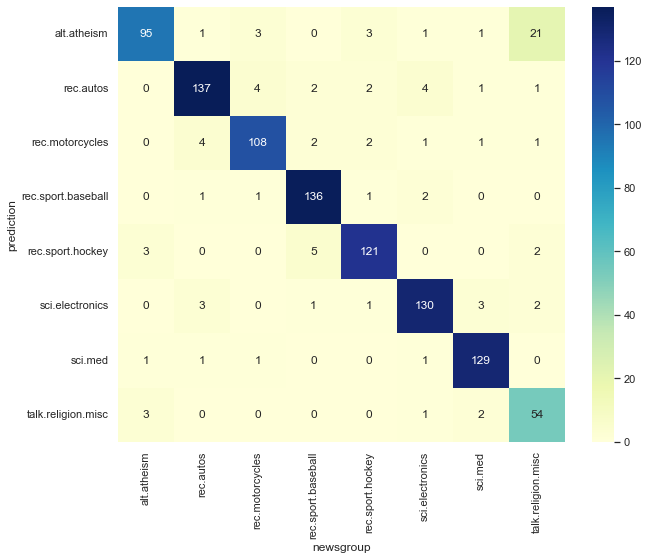

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_1,annot=True, fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
total_sample_each_type=confusion_matrix_1.sum()

In [ ]:
for t in news_type:
    recall=confusion_matrix_1.loc[t,t]/total_sample_each_type[t]*100
    recall="{:.2f}".format(recall)
    print(f'The recall of {t} is {recall}%')

The recall of talk.religion.misc is 66.67%
The recall of rec.motorcycles is 92.31%
The recall of rec.sport.hockey is 93.08%
The recall of alt.atheism is 93.14%
The recall of rec.sport.baseball is 93.15%
The recall of rec.autos is 93.20%
The recall of sci.med is 94.16%
The recall of sci.electronics is 92.86%


Our model performs pretty well in every classes except **talk.religion.misc** class which the **recall** only 66.67%

## Conclusion:

Despite we pretend that each word in text are **independent** events, our **Naive Bayes** algorithm actually performs really well on both **film reviews** and **newsgroup**:

> - For film reviews, our accuracy is 85.3%. 

> - For newsgroup, our accuracy is up to 91.1%

> - As we can see, when a review is correctly classified, the difference between probability is much bigger than when a review is misclassified.

> - This can be explained grouping by each topic are much more significantly different and easier to predict than positive/negative.

> - For both classes: positive and negative, the recall accuracy equals to each other => no bias

> - While for newsgroup, there is one exception when the recall for talk.religion.misc class only 66.67%

